In [1]:
import requests
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 발급받은 인코딩된 서비스키를 사용하세요.
service_key = 'mUglWToAvQmeYwqfOR1UwESkdwoUdkYmZTS5lWDf5pEGuh1gvgyfIy%2BtFKzTNsFYqE%2BM0a6NlwJGtxyhBV63sQ%3D%3D'

def get_stock_code(stock_name):
    """한국 주식 종목명을 입력받아 종목 코드 조회"""
    url = f"https://apis.data.go.kr/1160100/service/GetStockSecuritiesInfoService/getStockPriceInfo?serviceKey={service_key}&numOfRows=1&pageNo=1&resultType=json&itmsNm={stock_name}"
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        items = data.get('response', {}).get('body', {}).get('items', {}).get('item', [])
        
        if items:
            # 종목 코드 추출
            stock_code = items[0].get('srtnCd', '')  # 짧은 종목 코드 가져오기
            market_type = items[0].get('mrktCtg', '')  # 시장 구분 (KOSPI/KOSDAQ)
            
            # yfinance 형식으로 변환
            suffix = '.KS' if market_type == 'KOSPI' else '.KQ'
            return f"{stock_code}{suffix}"
        else:
            print("해당 종목명을 찾을 수 없습니다.")
            return None
    else:
        print(f"API 호출 실패: {response.status_code}")
        return None

def get_stock_data(stock_name, country='US', period='5y', interval='monthly'):
    """종목명 또는 심볼로 yfinance 데이터를 불러오기"""
    if country == 'KR':  # 한국 주식
        ticker = get_stock_code(stock_name)
    elif country == 'US':  # 미국 주식
        ticker = stock_name
    else:
        raise ValueError("지원되지 않는 country 값입니다. 'KR' 또는 'US' 중 하나를 선택하세요.")
    
    if ticker is None:
        return None

    # yfinance로 주식 데이터 불러오기
    stock = yf.Ticker(ticker)
    df = stock.history(period=period)

    # 데이터 재구성
    if interval == 'monthly':  # 월말 데이터
        df_resampled = df['Close'].resample('M').last().reset_index()
    elif interval == 'semi_monthly':  # 월중(15일) 및 월말 데이터
        df = df.reset_index()  # 인덱스를 초기화하여 `Date` 열로 변환
        df['Day'] = df['Date'].dt.day
        df['Month'] = df['Date'].dt.month
        df['Year'] = df['Date'].dt.year

        # 월말 데이터: 각 달의 마지막 날짜
        df['Month_End'] = df['Date'] == df.groupby(['Year', 'Month'])['Date'].transform('max')
        
        # 월중(15일) 데이터와 월말 데이터 필터링
        mid_month_data = df[df['Day'] == 15]  # 월중 (15일)
        end_month_data = df[df['Month_End']]  # 월말 데이터
        
        # 월중 및 월말 데이터를 병합
        df_resampled = pd.concat([mid_month_data, end_month_data]).sort_values('Date').reset_index(drop=True)
    else:
        raise ValueError("지원되지 않는 interval 값입니다. 'monthly', 'semi_monthly' 중 하나를 선택하세요.")

    # 필요한 열만 반환
    return df_resampled[['Date', 'Close']]

def cal_increase(stock_name, country='US', interval='monthly'):
    """주식의 월별 증가율 계산"""
    df = get_stock_data(stock_name, country=country, interval=interval)
    if df is not None:
        df['Increase'] = df['Close'].diff()
        df = df.dropna().reset_index(drop=True)
        return df
    else:
        print("데이터를 가져오지 못했습니다.")
        return None


In [8]:
def plot_stats_dual_axis(stats_df, interval):
    """
    통계 데이터를 이중 축으로 시각화.
    - 왼쪽 y축: Median (Increase)
    - 오른쪽 y축: Increase Count

    Parameters:
    - stats_df: DataFrame, 통계 데이터
    - interval: str, 주기 ('monthly', 'semi_monthly')
    """
    # 그래프 크기 설정
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # x축 데이터 설정
    x_labels = stats_df['Month'] if interval == 'monthly' else stats_df['Month-Period']
    
    # 왼쪽 y축: Median 꺾은선 그래프
    ax1.set_xlabel('Month' if interval == 'monthly' else 'Month-Period', fontsize=12)
    ax1.set_ylabel('Median (Increase)', fontsize=12, color='red')
    ax1.plot(x_labels, stats_df['Median'], marker='o', color='red', label='Median (Increase)', linewidth=2)
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # 오른쪽 y축: Increase Count 막대 그래프
    ax2 = ax1.twinx()  # 공유된 x축을 사용하는 두 번째 y축 생성
    ax2.set_ylabel('Increase Count', fontsize=12, color='darkorange')
    ax2.bar(x_labels, stats_df['Increase Count'], alpha=0.6, label='Increase Count (Max=5)', width=0.4, color='darkorange')
    ax2.tick_params(axis='y', labelcolor='black')

    # 그래프 제목 및 x축 레이블 설정
    title = 'Monthly Statistics' if interval == 'monthly' else 'Semi-Monthly Statistics'
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, fontsize=10)

    # 레전드 추가
    ax1.legend(loc='upper left', fontsize=12)
    ax2.legend(loc='upper right', fontsize=12)

    # 그래프 출력
    plt.tight_layout()
    plt.show()


def cal_data(stock_name, country='US', interval='monthly'):
    """
    주어진 종목 데이터를 기반으로 월별 또는 월중(15일) 및 월말 통계량 계산 및 그래프 출력.
    
    Parameters:
    - stock_name: str, 종목 이름
    - interval: str, 데이터 주기 ('monthly', 'semi_monthly')
    
    Returns:
    - DataFrame: 통계량이 포함된 결과 데이터프레임
    """
    if interval == 'monthly':
        df_monthly = cal_increase(stock_name, country=country, interval='monthly')
        monthly_increase_data = df_monthly['Increase']
        monthly_mean = monthly_increase_data.mean()                  # 평균    
        monthly_std = monthly_increase_data.std()                    # 표준편차 
        monthly_lower_bound = monthly_mean - 1.96 * monthly_std      # 하한
        monthly_upper_bound = monthly_mean + 1.96 * monthly_std      # 상한
        df_monthly['Increase'] = df_monthly['Increase'].clip(lower=monthly_lower_bound, upper=monthly_upper_bound)
        
        # 전체 데이터를 월별로 그룹화하여 통계량 계산
        df_monthly['Month'] = df_monthly['Date'].dt.month
        monthly_stats = df_monthly.groupby('Month')['Increase'].agg(
            Max='max',          # 최대 증가량
            Min='min',          # 최소 증가량
            Median='median',    # 증가량 중앙값
            Mean='mean',        # 증가량 평균
            Std='std',          # 표준편차
            Variance='var',     # 분산
            Q1=lambda x: x.quantile(0.25),  # 1사분위수 (25th Percentile)
            Q3=lambda x: x.quantile(0.75)   # 3사분위수 (75th Percentile)
        )

        # 양수인 증가량 개수 계산
        positive_counts = df_monthly[df_monthly['Increase'] > 0].groupby('Month')['Increase'].count()

        # 모든 월을 포함하여 결과 결합 및 누락 값 채우기
        monthly_stats = monthly_stats.join(positive_counts.rename('Increase Count')).reindex(range(1, 13), fill_value=0).reset_index()
        monthly_stats['Increase Count'] = monthly_stats['Increase Count'].fillna(0).astype(int)

        # 그래프 출력
        plot_stats_dual_axis(monthly_stats, interval='monthly')
        
        return monthly_stats

    elif interval == 'semi_monthly':
        df_semi_monthly = cal_increase(stock_name, country = country, interval='semi_monthly')
        semi_monthly_increase_data = df_semi_monthly['Increase']
        semi_monthly_mean = semi_monthly_increase_data.mean()
        semi_monthly_std = semi_monthly_increase_data.std()
        semi_monthly_lower_bound = semi_monthly_mean - 1.96 * semi_monthly_std
        semi_monthly_upper_bound = semi_monthly_mean + 1.96 * semi_monthly_std
        df_semi_monthly['Increase'] = df_semi_monthly['Increase'].clip(lower=semi_monthly_lower_bound, upper=semi_monthly_upper_bound)

        # 월중 및 월말 데이터 처리
        df_semi_monthly['Period'] = df_semi_monthly['Date'].dt.day.apply(
            lambda x: 'Mid' if x < 20 else 'End'
        )  # 15일 이전을 'Mid', 이후를 'End'로 구분

        df_semi_monthly['Month'] = df_semi_monthly['Date'].dt.month
        df_semi_monthly['Month-Period'] = df_semi_monthly['Month'].astype(str) + '-' + df_semi_monthly['Period']

        # 월-기간별 통계량 계산
        semi_monthly_stats = df_semi_monthly.groupby('Month-Period')['Increase'].agg(
            Max='max',          # 최대 증가량
            Min='min',          # 최소 증가량
            Median='median',    # 증가량 중앙값
            Mean='mean',        # 증가량 평균
            Std='std',          # 표준편차
            Variance='var',     # 분산
            Q1=lambda x: x.quantile(0.25),  # 1사분위수 (25th Percentile)
            Q3=lambda x: x.quantile(0.75)   # 3사분위수 (75th Percentile)
        )

        # 양수인 증가량 개수 계산
        positive_counts_semi = df_semi_monthly[df_semi_monthly['Increase'] > 0].groupby('Month-Period')['Increase'].count()

        # 결과 결합 및 누락 값 처리
        semi_monthly_stats = semi_monthly_stats.join(positive_counts_semi.rename('Increase Count')).fillna(0).reset_index()
        semi_monthly_stats['Increase Count'] = semi_monthly_stats['Increase Count'].astype(int)

        # Month-Period 순서 정렬
        semi_monthly_stats['Sort_Key'] = semi_monthly_stats['Month-Period'].apply(
            lambda x: (int(x.split('-')[0]), 1 if x.split('-')[1] == 'Mid' else 2)
        )

        # 정렬 후 정렬 키 삭제
        semi_monthly_stats = semi_monthly_stats.sort_values('Sort_Key').drop(columns=['Sort_Key']).reset_index(drop=True)

        # 그래프 출력
        plot_stats_dual_axis(semi_monthly_stats, interval='semi_monthly')
        
        return semi_monthly_stats


In [13]:
def predict_increase(stock_name, country='US', interval='monthly'):
    if interval == 'monthly':
        df_monthly = cal_increase(stock_name, country=country, interval='monthly')
        # SARIMA 모델 적용 (계절 주기 12 설정)
        model = SARIMAX(df_monthly['Increase'], order=(2, 1, 1), seasonal_order=(0, 1, 1, 12))
        monthly_model_fit = model.fit()

        # 12개월(1년) 예측
        monthly_forecast = monthly_model_fit.forecast(steps=12)

        # 예측 월 생성 (마지막 관측 월 이후 12개월)
        monthly_start_date = df_monthly['Date'].iloc[-1]  # 마지막 데이터의 날짜
        monthly_forecast_dates = pd.date_range(start=monthly_start_date + pd.DateOffset(months=1), periods=12, freq='M')

        # 예측 결과와 월 정보를 함께 데이터프레임으로 정리
        monthly_forecast_df = pd.DataFrame({'Date': monthly_forecast_dates, 'Predicted_Increase': monthly_forecast})
        return monthly_forecast_df
    elif interval =='semi_monthly':
        df_semi_monthly = cal_increase(stock_name, country=country, interval='semi_monthly')
        
        # 'Date' 열을 datetime 형식으로 변환
        if 'Date' in df_semi_monthly.columns and not pd.api.types.is_datetime64_any_dtype(df_semi_monthly['Date']):
            df_semi_monthly['Date'] = pd.to_datetime(df_semi_monthly['Date'])

        # 'Date'를 인덱스로 설정
        if df_semi_monthly.index.name != 'Date':
            df_semi_monthly.set_index('Date', inplace=True)

        model = SARIMAX(df_semi_monthly['Increase'], order=(2, 1, 1), seasonal_order=(0, 1, 1, 12))
        semi_monthly_model_fit = model.fit()

        # 12개월 예측
        semi_monthly_forecast = semi_monthly_model_fit.forecast(steps=24)

        # 예측 날짜 생성: 15일과 월말
        last_date = df_semi_monthly.index[-1]
        forecast_dates = []
        for i in range(1, 13):  # 12개월 동안
            mid_month = (last_date + pd.DateOffset(months=i)).replace(day=15)  # 15일
            end_month = (last_date + pd.DateOffset(months=i + 1)).replace(day=1) - pd.DateOffset(days=1)  # 월말
            forecast_dates.extend([mid_month, end_month])

        # 결과 데이터프레임 생성
        semi_monthly_forecast_df = pd.DataFrame({
            'Date': forecast_dates, 
            'Predicted_Increase': semi_monthly_forecast
        })
        return semi_monthly_forecast_df

In [14]:
cal_increase('삼성전자', country='KR', interval='monthly')

,Date,Close,Increase
0,2019-12-30 00:00:00+09:00,49356.187500,5149.152344
1,2020-01-15 00:00:00+09:00,52186.636719,2830.449219
2,2020-01-31 00:00:00+09:00,49886.898438,-2299.738281
3,2020-02-28 00:00:00+09:00,47940.949219,-1945.949219
4,2020-03-31 00:00:00+09:00,42547.636719,-5393.312500
...,...,...,...
94,2024-09-30 00:00:00+09:00,61500.000000,-12385.437500
95,2024-10-15 00:00:00+09:00,61000.000000,-500.000000
96,2024-10-31 00:00:00+09:00,59200.000000,-1800.000000
97,2024-11-15 00:00:00+09:00,53500.000000,-5700.000000


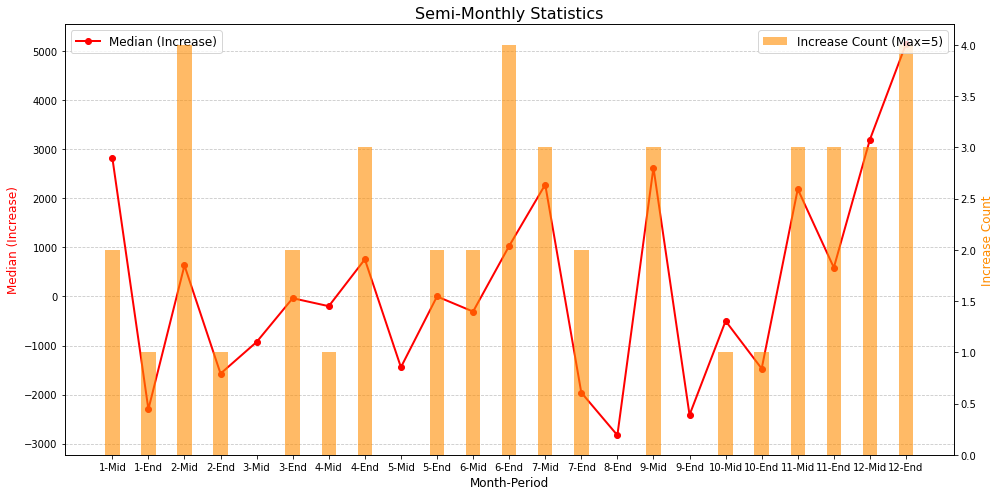

,Month-Period,Max,Min,Median,Mean,Std,Variance,Q1,Q3,Increase Count
0,1-Mid,6476.687500,-4533.421875,2830.460938,1591.242188,5608.687408,3.145737e+07,-851.480469,4653.574219,2
1,1-End,5888.593750,-5551.437500,-2299.753906,-1571.188281,4528.496371,2.050728e+07,-4710.710938,-1182.632812,1
2,2-Mid,2035.523438,376.867188,632.515625,919.355469,762.395083,5.812463e+05,463.791016,1088.080078,4
3,2-End,197.101562,-1945.933594,-1572.890625,-1312.424219,858.595134,7.371856e+05,-1695.851562,-1544.546875,1
4,3-Mid,-647.687500,-1601.640625,-928.175781,-1026.419922,425.139980,1.807440e+05,-1213.468750,-741.126953,0
5,3-End,7751.978114,-5393.324219,-35.421875,1301.823748,5005.686189,2.505689e+07,-226.335938,4412.222656,2
6,4-Mid,2509.250000,-2841.015625,-198.007812,-176.591146,2675.197109,7.156680e+06,-1519.511719,1155.621094,1
7,4-End,2004.867188,-4653.015625,757.617188,-570.087500,2853.883149,8.144649e+06,-2416.296875,1456.390625,3
8,5-Mid,-970.925781,-1915.753906,-1443.339844,-1443.339844,668.094374,4.463501e+05,-1679.546875,-1207.132812,0
9,5-End,6699.453125,-3960.023438,0.000000,869.911719,4002.918791,1.602336e+07,-929.359375,2539.488281,2


In [15]:
cal_data('삼성전자', country='KR', interval='monthly')

In [16]:
predict_increase('삼성전자', country='KR', interval='semi_monthly')

C:\Users\User\.conda\envs\test01\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\User\.conda\envs\test01\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\User\.conda\envs\test01\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\User\.conda\envs\test01\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\U

,Date,Predicted_Increase
99,2024-12-15 00:00:00+09:00,-1390.686213
100,2024-12-31 00:00:00+09:00,-2028.315086
101,2025-01-15 00:00:00+09:00,-79.645372
102,2025-01-31 00:00:00+09:00,2232.092064
103,2025-02-15 00:00:00+09:00,1315.666594
104,2025-02-28 00:00:00+09:00,-670.028310
105,2025-03-15 00:00:00+09:00,-3033.035517
106,2025-03-31 00:00:00+09:00,-3963.255207
107,2025-04-15 00:00:00+09:00,-857.844410
108,2025-04-30 00:00:00+09:00,-1899.643604


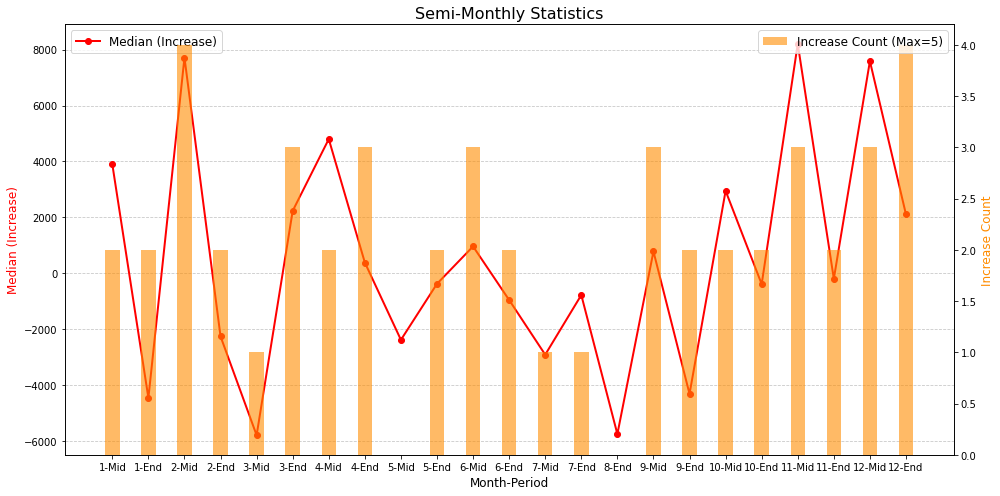

,Month-Period,Max,Min,Median,Mean,Std,Variance,Q1,Q3,Increase Count
0,1-Mid,8640.335938,-7366.171875,3896.289062,1723.484375,8221.489114,6.759288e+07,-1734.941406,6268.312500,2
1,1-End,13294.117188,-10203.648438,-4466.468750,-1115.781250,8915.868909,7.949272e+07,-4800.171875,597.265625,2
2,2-Mid,14135.062500,3151.187500,7718.453125,8180.789062,4658.629955,2.170283e+07,5525.201172,10374.041016,4
3,2-End,9120.351562,-5321.757812,-2264.921875,982.642187,6702.931030,4.492928e+07,-3887.085938,7266.625000,2
4,3-Mid,4977.125000,-10142.914062,-5801.320312,-4192.107422,6497.962698,4.222352e+07,-7637.562500,-2355.865234,1
5,3-End,20611.724267,-4371.445312,2230.953125,4857.691728,10475.631718,1.097389e+08,-3840.140625,9657.367188,3
6,4-Mid,5184.812500,-9742.132812,4800.210938,80.963542,8509.224176,7.240690e+07,-2470.960938,4992.511719,2
7,4-End,4383.960938,-13959.093750,380.132812,-3485.212500,7704.851848,5.936474e+07,-9120.398438,889.335938,3
8,5-Mid,-1710.546875,-3063.289062,-2386.917969,-2386.917969,956.533174,9.149557e+05,-2725.103516,-2048.732422,0
9,5-End,20611.724267,-4383.960938,-380.132812,5968.752666,11075.711060,1.226714e+08,-960.039062,14956.171875,2


In [17]:
cal_data('SK하이닉스', country='KR', interval='semi_monthly')

In [18]:
predict_increase('SK하이닉스', country='KR', interval='semi_monthly')

C:\Users\User\.conda\envs\test01\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\User\.conda\envs\test01\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\User\.conda\envs\test01\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


,Date,Predicted_Increase
99,2024-12-15 00:00:00+09:00,-3492.091077
100,2024-12-31 00:00:00+09:00,-794.894035
101,2025-01-15 00:00:00+09:00,5007.308560
102,2025-01-31 00:00:00+09:00,8311.037644
103,2025-02-15 00:00:00+09:00,-3541.891429
104,2025-02-28 00:00:00+09:00,-12547.149198
105,2025-03-15 00:00:00+09:00,-7088.443551
106,2025-03-31 00:00:00+09:00,574.398265
107,2025-04-15 00:00:00+09:00,2288.409059
108,2025-04-30 00:00:00+09:00,-2384.818550


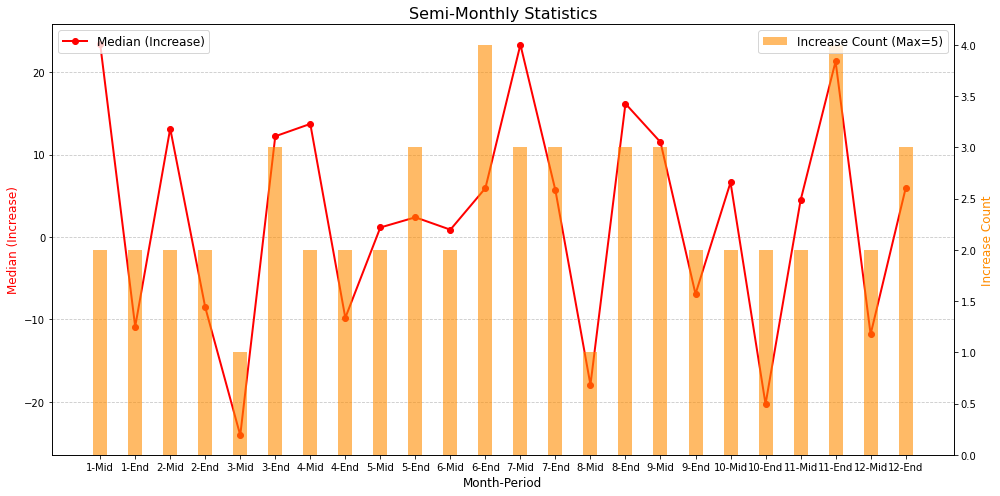

,Month-Period,Max,Min,Median,Mean,Std,Variance,Q1,Q3,Increase Count
0,1-Mid,40.163330,6.677999,23.420665,23.420665,23.677704,560.633682,15.049332,31.791997,2
1,1-End,50.040001,-59.523739,-10.876648,-10.315147,42.756553,1828.122860,-40.020020,8.804668,2
2,2-Mid,41.020004,-4.763336,13.160004,16.472224,23.070689,532.256668,4.198334,27.090004,2
3,2-End,1.430008,-39.343338,-8.529999,-12.523062,16.884616,285.090263,-17.333313,1.161331,2
4,3-Mid,10.813324,-38.309998,-24.053345,-18.900841,20.941630,438.551876,-28.522507,-14.431679,1
5,3-End,65.861045,-13.336670,12.219986,16.431008,32.158474,1034.167445,-9.599331,27.010010,3
6,4-Mid,23.640015,-14.309998,13.722000,7.684006,19.682324,387.393889,-0.293999,18.681007,2
7,4-End,21.800003,-59.523739,-9.803345,-17.441418,33.419193,1116.842487,-43.150009,3.469997,2
8,5-Mid,2.040009,-9.289993,1.152668,-2.032439,6.300866,39.700915,-4.068663,1.596338,2
9,5-End,37.579987,-37.500000,2.388668,-4.302937,29.734134,884.118737,-28.073334,4.089996,3


In [19]:
cal_data('TSLA', country='US', interval='monthly')

In [20]:
predict_increase('TSLA', country='US', interval='monthly')

C:\Users\User\.conda\envs\test01\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\User\.conda\envs\test01\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\User\.conda\envs\test01\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


,Date,Predicted_Increase
101,2024-12-15 00:00:00-05:00,-14.910758
102,2024-12-31 00:00:00-05:00,10.668027
103,2025-01-15 00:00:00-05:00,-0.138193
104,2025-01-31 00:00:00-05:00,9.859352
105,2025-02-15 00:00:00-05:00,-2.780099
106,2025-02-28 00:00:00-05:00,-3.081512
107,2025-03-15 00:00:00-04:00,-5.538877
108,2025-03-31 00:00:00-04:00,4.194131
109,2025-04-15 00:00:00-04:00,-16.342974
110,2025-04-30 00:00:00-04:00,13.708744
